Pipeline
======

Create a pipeline, then turn it into a script.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Build up list of station IDs and names from dataframes to organize the turnstiles.

In [2]:
columns = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
           'DATE', 'TIME', 'ENTRIES', 'EXITS']  # I think EXITS has some extra whitespace attached to it...

# works for 20141018 and after
def load_turnstile(filename, columns=columns):
    df = pd.read_csv(filename, header=0,# usecols=columns,
                     parse_dates=[['DATE', 'TIME']], infer_datetime_format=True,)
    df.columns = df.columns.str.strip().str.lower().str.replace('/', '_')
    return df

In [8]:
test = load_turnstile('raw_data/turnstile_170603.txt')
test.head()

,date_time,c_a,unit,scp,station,linename,division,desc,entries,exits
0,2017-05-27 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195217,2098317
1,2017-05-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195240,2098318
2,2017-05-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195256,2098347
3,2017-05-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195346,2098432
4,2017-05-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195518,2098491


In [6]:
test.set_index(['unit', 'scp', 'date_time'], inplace=True)
test.head()

c_a station linename division     desc  \
unit scp      date_time                                                      
R051 02-00-00 2017-05-27 00:00:00  A002   59 ST  NQR456W      BMT  REGULAR   
              2017-05-27 04:00:00  A002   59 ST  NQR456W      BMT  REGULAR   
              2017-05-27 08:00:00  A002   59 ST  NQR456W      BMT  REGULAR   
              2017-05-27 12:00:00  A002   59 ST  NQR456W      BMT  REGULAR   
              2017-05-27 16:00:00  A002   59 ST  NQR456W      BMT  REGULAR   

                                   entries    exits  
unit scp      date_time                              
R051 02-00-00 2017-05-27 00:00:00  6195217  2098317  
              2017-05-27 04:00:00  6195240  2098318  
              2017-05-27 08:00:00  6195256  2098347  
              2017-05-27 12:00:00  6195346  2098432  
              2017-05-27 16:00:00  6195518  2098491

In [9]:
# test.loc['R072']

In [ ]:
turnstile_units = test.unit.unique()

Read in saved dataset of staton information from the MTA.

In [ ]:
stations = pd.read_csv('other_data/Remote-Booth-Station.csv', header=0)
stations.head()

In [ ]:
station_units = stations.Remote.unique()

In [ ]:
turnst = [x for x in turnstile_units if x not in station_units]
st = [x for x in station_units if x not in turnstile_units]

print(turnst, st, sep='\n')

In [10]:
test[test.unit == 'R072'].iloc[0]

date_time    2017-05-27 00:00:00
c_a                         R550
unit                        R072
scp                     00-00-00
station          34 ST-HUDSON YD
linename                       7
division                     IRT
desc                     REGULAR
entries                    21065
exits                      93422
Name: 183685, dtype: object

The stations in `turnst` (those within the turnstile data but not within the station detail csv) are the new stations that have opened up along the Q (2nd Ave) and 7 (Hudson Yards). I am assuming that the stations present within the station detail file that aren't in the turnstiles (for this one turnstile) are those that have closed or otherwise weren't operating during that week.

This shouldn't matter, as I will be combining things by the unit value anyway, which should be better than the previous way I had been doing it (matching station names and line numbers).

In [ ]:
import os

files = os.listdir('modern')
filenames = [f'modern/{f}' for f in files]
# filenames

In [11]:
def pull_single_station(frame):
    frame.sort_values(['unit', 'date_time'], inplace=True)
    frame[['d_entry', 'd_exit']] = frame.groupby(['unit', 'scp'])[['entries', 'exits']].diff()
    return frame

In [12]:
# test.columns
test_diff = pull_single_station(test)
test_diff.sort_index(inplace=True)
test_diff.head()

,date_time,c_a,unit,scp,station,linename,division,desc,entries,exits,d_entry,d_exit
0,2017-05-27 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195217,2098317,NaN,NaN
1,2017-05-27 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195240,2098318,23.0,1.0
2,2017-05-27 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195256,2098347,16.0,29.0
3,2017-05-27 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195346,2098432,90.0,85.0
4,2017-05-27 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6195518,2098491,172.0,59.0


/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


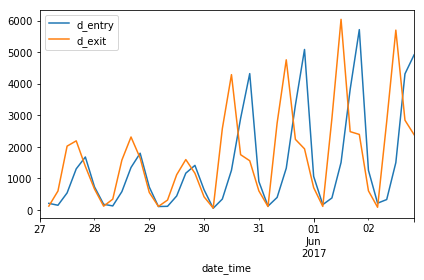

In [13]:
sums = test_diff.groupby(by=['unit', 'date_time']).sum()
sums.loc['R072'].plot(y=['d_entry', 'd_exit'])

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


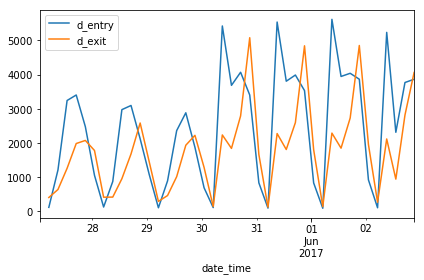

In [14]:
sums.loc['R572'].plot(y=['d_entry', 'd_exit'])

In [15]:
test_diff[['d_entry', 'd_exit']] = np.abs(test_diff[['d_entry', 'd_exit']])
test_diff.loc[test_diff.d_entry > 1000000, 'd_entry'] = np.NaN
test_diff.loc[test_diff.d_exit > 1000000, 'd_exit'] = np.NaN

In [ ]:
# test_diff.groupby('unit').plot(y='diffs')

In [16]:
test_diff.iloc[151190:151200]

,date_time,c_a,unit,scp,station,linename,division,desc,entries,exits,d_entry,d_exit
151190,2017-05-27 20:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,9397,0,0.0,0.0
151191,2017-05-28 00:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,9397,0,0.0,0.0
151192,2017-05-28 04:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,9397,0,0.0,0.0
151193,2017-05-28 08:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,9398,0,1.0,0.0
151194,2017-05-28 20:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,RECOVR AUD,34209792,51118080,NaN,NaN
151195,2017-05-29 16:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,34209794,51118080,2.0,0.0
151196,2017-05-29 20:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,34209794,51118080,0.0,0.0
151197,2017-05-30 00:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,34209795,51118080,1.0,0.0
151198,2017-05-30 04:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,34209795,51118080,0.0,0.0
151199,2017-05-30 08:00:00,R238,R046,00-05-00,GRD CNTRL-42 ST,4567S,IRT,REGULAR,34209795,51118080,0.0,0.0


In [ ]:
sums.reset_index(inplace=True)
sums.plot(y=['d_entry', 'd_exit'], subplots=True, sharex=True)

In [ ]:
sums.reset_index(inplace=True)
sums.set_index(['unit', 'date_time'], inplace=True)
sums.head()

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


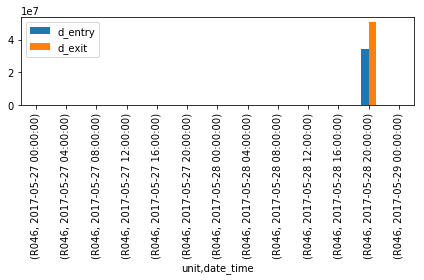

In [19]:
temp = sums.loc[('R046', pd.datetime(2017, 5, 27)):('R046', pd.datetime(2017, 5, 29))]
temp.plot.bar(y=['d_entry', 'd_exit'])

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


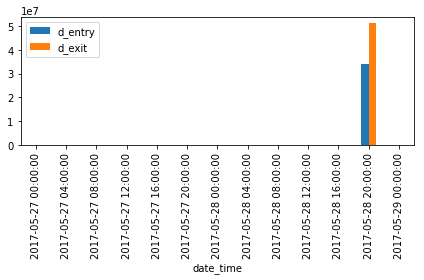

In [20]:
temp.loc['R046'].plot.bar(y=['d_entry', 'd_exit'])

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


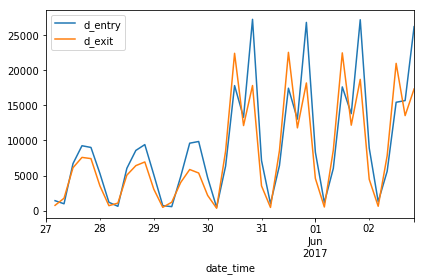

In [28]:
gcs = test_diff.loc[test_diff.unit == 'R046']
gcs.groupby('date_time').sum().plot.line(y=['d_entry', 'd_exit'])

In [ ]:
gcs.to_csv()